In [ ]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm

DATA_ROOT = Path("/root/projects/automatic-lens-correction/lens-correction-train-cleaned")

# Build pairs: original (distorted) ↔ generated (corrected)
originals = sorted(DATA_ROOT.glob("*_original.jpg"))
generated = [p.parent / p.name.replace("_original.jpg", "_generated.jpg") for p in originals]
pairs = [(o, g) for o, g in zip(originals, generated) if g.exists()]

distorted_paths = [p[0] for p in pairs]
corrected_paths = [p[1] for p in pairs]

print(f"Total pairs found: {len(distorted_paths)}")

Total pairs found: 23118


In [3]:
# Run full dataset cleaning — NO early break
records = []

for dist_p, corr_p in tqdm(
    zip(distorted_paths, corrected_paths),
    total=len(distorted_paths)
):
    dist = cv2.imread(str(dist_p))
    corr = cv2.imread(str(corr_p))

    if dist is None or corr is None:
        records.append({
            "image_id": dist_p.stem,
            "status": "corrupted",
            "category": "remove",
            "weight": 0.0,
        })
        continue

    h, w = dist.shape[:2]
    is_portrait = h > w

    # Rotate portrait for analysis
    if is_portrait:
        dist_analyze = cv2.rotate(dist, cv2.ROTATE_90_CLOCKWISE)
        corr_analyze = cv2.rotate(corr, cv2.ROTATE_90_CLOCKWISE)
        h_a, w_a = dist_analyze.shape[:2]
    else:
        dist_analyze = dist
        corr_analyze = corr
        h_a, w_a = h, w

    overall_diff = cv2.absdiff(dist_analyze, corr_analyze).mean()

    # Tight center check
    cy_s, cy_e = int(h_a * 0.49), int(h_a * 0.51)
    cx_s, cx_e = int(w_a * 0.49), int(w_a * 0.51)
    center_diff = cv2.absdiff(dist_analyze, corr_analyze).mean(axis=2)[cy_s:cy_e, cx_s:cx_e].mean()

    # Corner check
    diff_map = cv2.absdiff(dist_analyze, corr_analyze).mean(axis=2)
    corner_diff = np.array([
        diff_map[:60, :60].mean(),
        diff_map[:60, -60:].mean(),
        diff_map[-60:, :60].mean(),
        diff_map[-60:, -60:].mean(),
    ]).mean()

    barrel_ratio = corner_diff / (center_diff + 1e-6)

    # Category assignment
    if overall_diff < 0.5:
        category = "identical"
        weight = 0.0
    elif overall_diff < 2.0:
        category = "mild"
        weight = 0.3
    elif overall_diff > 20.0:
        category = "heavy"
        weight = 5.0
    else:
        category = "normal"
        weight = 1.0

    records.append({
        "image_id": dist_p.stem,
        "dist_path": str(dist_p),
        "corr_path": str(corr_p),
        "height": h,
        "width": w,
        "is_portrait": is_portrait,
        "overall_diff": overall_diff,
        "center_diff": center_diff,
        "corner_diff": corner_diff,
        "barrel_ratio": barrel_ratio,
        "category": category,
        "weight": weight,
        "use_in_train": category != "identical",
        "status": "ok",
    })

df_full = pd.DataFrame(records)
df_full.to_csv("full_dataset_clean.csv", index=False)

# ── Summary ──
print("\n" + "=" * 55)
print("FULL DATASET CLEANING SUMMARY")
print("=" * 55)
print(f"\nTotal pairs:          {len(df_full):,}")
print(f"Corrupted files:      {(df_full['status']=='corrupted').sum():,}")

ok_mask = df_full["status"] == "ok"
print(f"\nOrientation (valid only):")
print(f"  Landscape:          {(~df_full.loc[ok_mask, 'is_portrait']).sum():,}")
print(f"  Portrait:           {df_full.loc[ok_mask, 'is_portrait'].sum():,}")

print(f"\nHeight groups:")
main = df_full[ok_mask & (df_full["height"] >= 1342) & (df_full["height"] <= 1380)]
tall = df_full[ok_mask & (df_full["height"] > 1380)]
print(f"  Main  (1342-1380):  {len(main):,}")
print(f"  Tall  (>1380):      {len(tall):,}")

print(f"\nCategories:")
for cat in ["identical", "mild", "normal", "heavy"]:
    subset = df_full[df_full["category"] == cat]
    pct = 100 * len(subset) / len(df_full)
    keep = subset["use_in_train"].sum()
    w = subset["weight"].iloc[0] if len(subset) > 0 else 0
    print(f"  {cat:12s}: {len(subset):6,} ({pct:5.1f}%)  weight={w}")

print(f"\nFINAL TRAINING SET:   {df_full['use_in_train'].sum():,} images")
print(f"REMOVED:              {(~df_full['use_in_train']).sum():,} images")

# ── Barrel ratio health check ──
clean = df_full[df_full["use_in_train"]]
suspicious = clean[clean["barrel_ratio"] < 1.2]
print(f"\nSuspicious barrel ratio (<1.2): {len(suspicious):,}")
print("  These may have non-barrel corrections")
print("  Consider reviewing before k1/k2 extraction")

100%|██████████| 23118/23118 [34:44<00:00, 11.09it/s] 



FULL DATASET CLEANING SUMMARY

Total pairs:          23,118
Corrupted files:      0

Orientation (valid only):
  Landscape:          22,867
  Portrait:           251

Height groups:
  Main  (1342-1380):  22,833
  Tall  (>1380):      284

Categories:
  identical   :    134 (  0.6%)  weight=0.0
  mild        :    699 (  3.0%)  weight=0.3
  normal      : 22,138 ( 95.8%)  weight=1.0
  heavy       :    147 (  0.6%)  weight=5.0

FINAL TRAINING SET:   22,984 images
REMOVED:              134 images

Suspicious barrel ratio (<1.2): 2,386
  These may have non-barrel corrections
  Consider reviewing before k1/k2 extraction


In [4]:
# Diagnose the suspicious barrel ratio group (barrel_ratio < 1.2)
import matplotlib.pyplot as plt

df = pd.read_csv("full_dataset_clean.csv")

suspicious = df[
    (df["barrel_ratio"] < 1.2) & (df["use_in_train"] == True)
].copy()

normal_barrel = df[
    (df["barrel_ratio"] >= 1.2) & (df["use_in_train"] == True)
].copy()

print(f"Suspicious:    {len(suspicious):,}")
print(f"Normal barrel: {len(normal_barrel):,}")

print(f"\nSuspicious overall_diff distribution:")
print(f"  Mean:   {suspicious['overall_diff'].mean():.3f}")
print(f"  Median: {suspicious['overall_diff'].median():.3f}")
print(f"  <2.0:   {(suspicious['overall_diff'] < 2.0).sum():,}")
print(f"  2-5:    {((suspicious['overall_diff'] >= 2) & (suspicious['overall_diff'] < 5)).sum():,}")
print(f"  5-10:   {((suspicious['overall_diff'] >= 5) & (suspicious['overall_diff'] < 10)).sum():,}")
print(f"  >10:    {(suspicious['overall_diff'] >= 10).sum():,}")

print(f"\nNormal barrel overall_diff distribution:")
print(f"  Mean:   {normal_barrel['overall_diff'].mean():.3f}")
print(f"  Median: {normal_barrel['overall_diff'].median():.3f}")

Suspicious:    2,386
Normal barrel: 20,598

Suspicious overall_diff distribution:
  Mean:   6.285
  Median: 6.113
  <2.0:   410
  2-5:    424
  5-10:   1,253
  >10:    299

Normal barrel overall_diff distribution:
  Mean:   6.942
  Median: 6.398


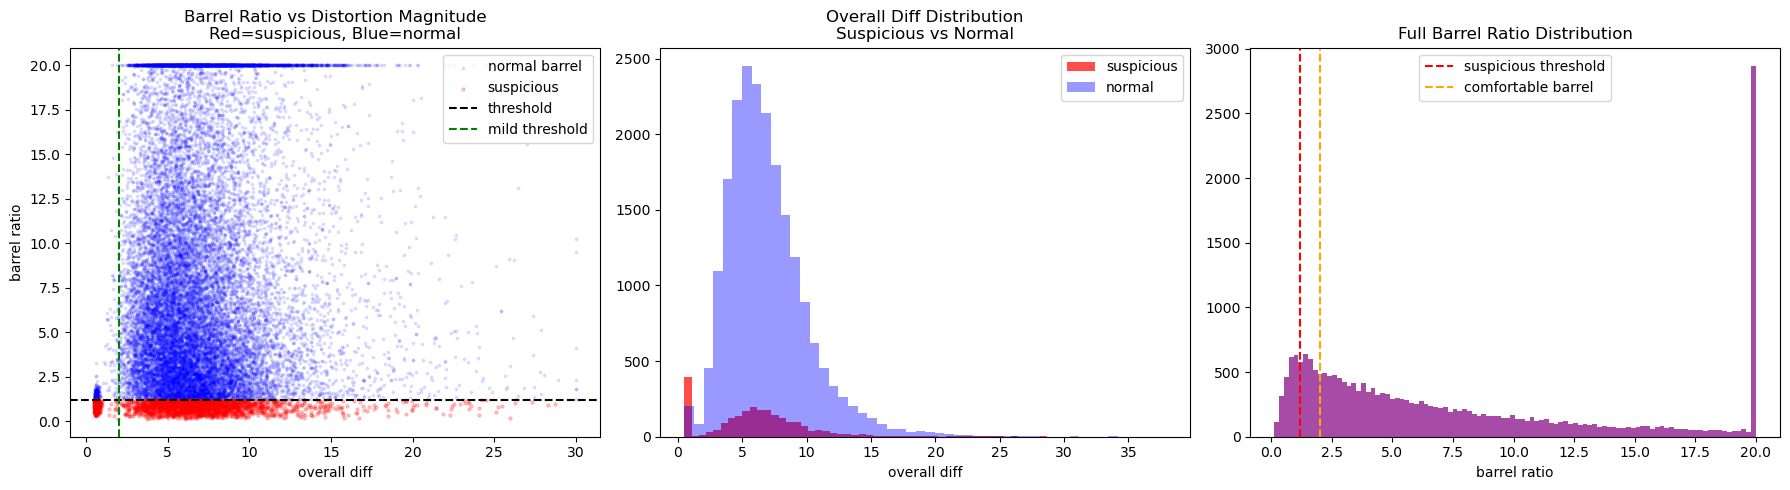

In [5]:
# Key plots: barrel ratio vs overall diff, distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(
    normal_barrel["overall_diff"].clip(0, 30),
    normal_barrel["barrel_ratio"].clip(0, 20),
    alpha=0.1, s=3, color="blue", label="normal barrel",
)
axes[0].scatter(
    suspicious["overall_diff"].clip(0, 30),
    suspicious["barrel_ratio"].clip(0, 20),
    alpha=0.2, s=5, color="red", label="suspicious",
)
axes[0].axhline(y=1.2, color="black", linestyle="--", label="threshold")
axes[0].axvline(x=2.0, color="green", linestyle="--", label="mild threshold")
axes[0].set_xlabel("overall diff")
axes[0].set_ylabel("barrel ratio")
axes[0].set_title("Barrel Ratio vs Distortion Magnitude\nRed=suspicious, Blue=normal")
axes[0].legend()

axes[1].hist(suspicious["overall_diff"], bins=50, color="red", alpha=0.7, label="suspicious")
axes[1].hist(normal_barrel["overall_diff"], bins=50, color="blue", alpha=0.4, label="normal")
axes[1].set_xlabel("overall diff")
axes[1].set_title("Overall Diff Distribution\nSuspicious vs Normal")
axes[1].legend()

axes[2].hist(
    df[df["use_in_train"]]["barrel_ratio"].clip(0, 20),
    bins=100, color="purple", alpha=0.7,
)
axes[2].axvline(x=1.2, color="red", linestyle="--", label="suspicious threshold")
axes[2].axvline(x=2.0, color="orange", linestyle="--", label="comfortable barrel")
axes[2].set_xlabel("barrel ratio")
axes[2].set_title("Full Barrel Ratio Distribution")
axes[2].legend()

plt.tight_layout()
plt.savefig("suspicious_analysis.png", dpi=150)
plt.show()

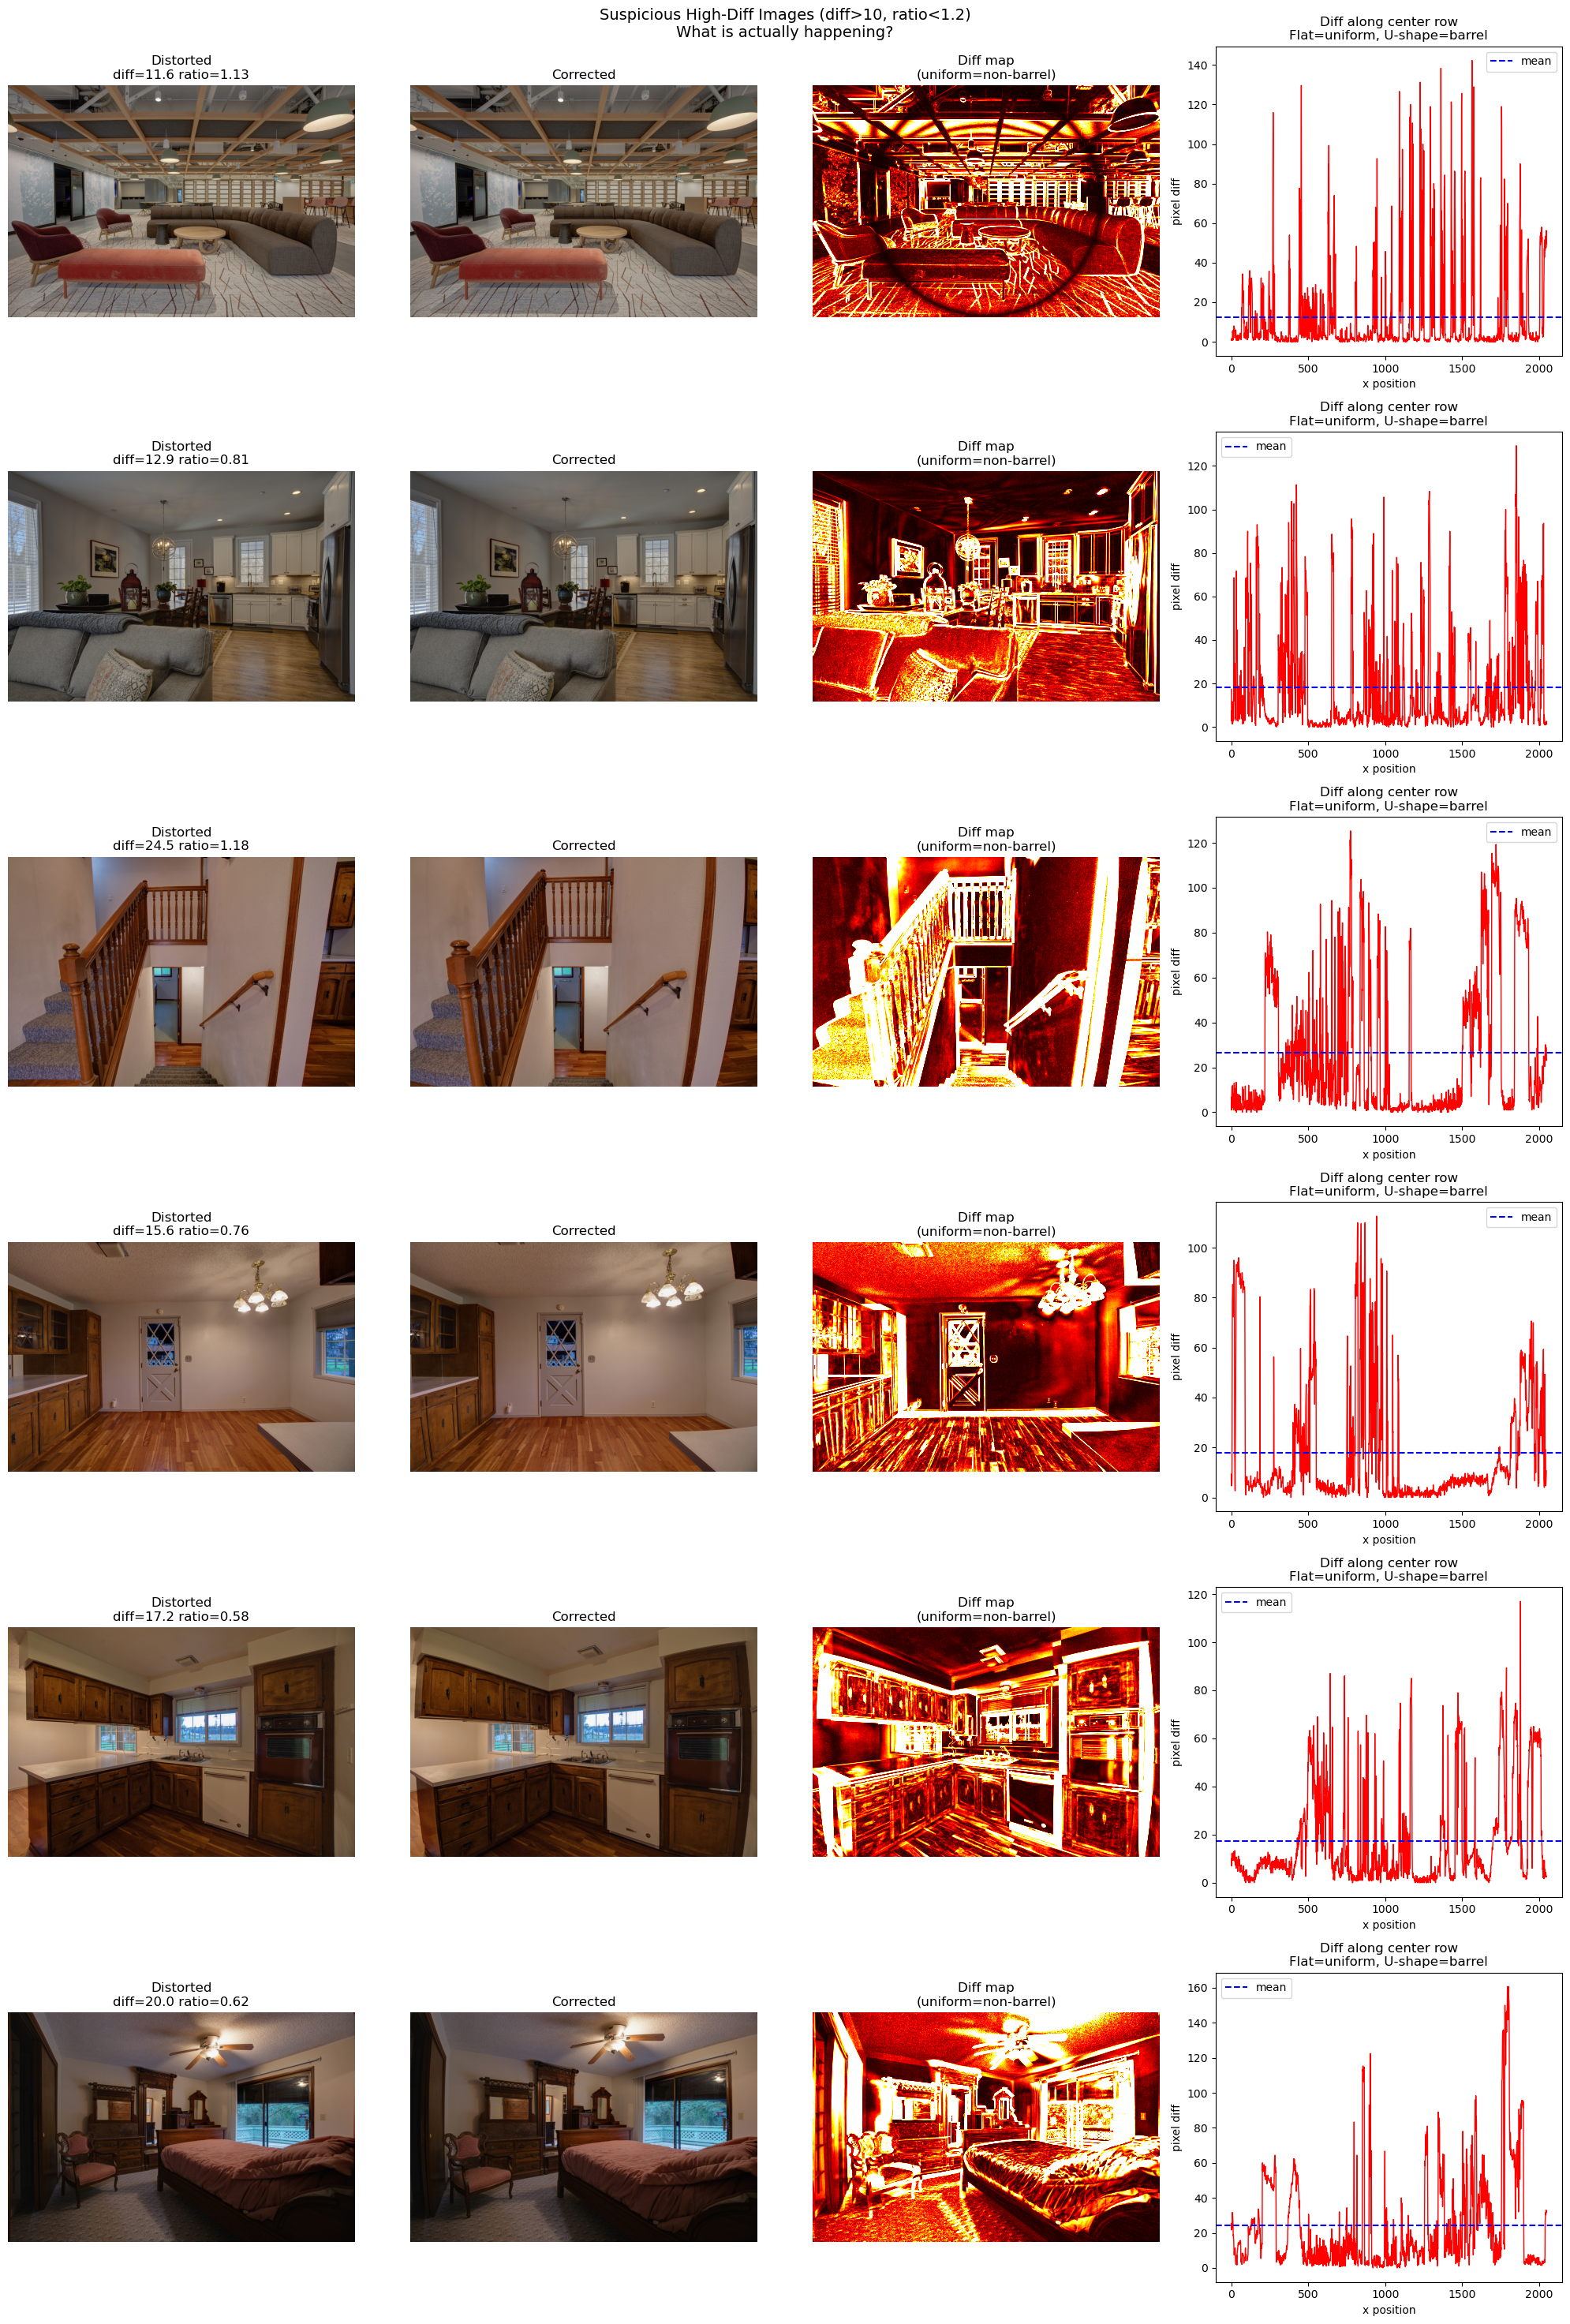

In [6]:
# Get suspicious images with HIGH diff (clearly not JPEG noise)
suspicious_high = df[
    (df["barrel_ratio"] < 1.2)
    & (df["overall_diff"] > 10)
    & (df["use_in_train"] == True)
].head(6)

fig, axes = plt.subplots(6, 4, figsize=(20, 30))
fig.suptitle(
    "Suspicious High-Diff Images (diff>10, ratio<1.2)\nWhat is actually happening?",
    fontsize=14,
)

for i, (_, row) in enumerate(suspicious_high.iterrows()):
    dist = cv2.imread(row["dist_path"])
    corr = cv2.imread(row["corr_path"])

    if dist is None or corr is None:
        continue

    h, w = dist.shape[:2]
    diff_map = cv2.absdiff(dist, corr).mean(axis=2)
    center_row_diff = diff_map[h // 2, :]

    axes[i, 0].imshow(cv2.cvtColor(dist, cv2.COLOR_BGR2RGB))
    axes[i, 0].set_title(
        f"Distorted\ndiff={row['overall_diff']:.1f} ratio={row['barrel_ratio']:.2f}"
    )
    axes[i, 0].axis("off")

    axes[i, 1].imshow(cv2.cvtColor(corr, cv2.COLOR_BGR2RGB))
    axes[i, 1].set_title("Corrected")
    axes[i, 1].axis("off")

    axes[i, 2].imshow(diff_map, cmap="hot", vmin=0, vmax=30)
    axes[i, 2].set_title("Diff map\n(uniform=non-barrel)")
    axes[i, 2].axis("off")

    axes[i, 3].plot(center_row_diff, color="red", linewidth=1)
    axes[i, 3].set_title("Diff along center row\nFlat=uniform, U-shape=barrel")
    axes[i, 3].set_xlabel("x position")
    axes[i, 3].set_ylabel("pixel diff")
    axes[i, 3].axhline(
        y=center_row_diff.mean(), color="blue", linestyle="--", label="mean"
    )
    axes[i, 3].legend()

plt.tight_layout()
plt.savefig("suspicious_investigation.png", dpi=120)
plt.show()

In [7]:
# Shift detection on suspicious high-diff images (phase correlation)
suspicious_high = df[
    (df["barrel_ratio"] < 1.2) & (df["overall_diff"] > 10)
].head(10)

print("Shift detection on suspicious images:")
print(f"{'Image':<30} {'dx':>8} {'dy':>8} {'shift_mag':>12} {'verdict':>15}")
print("─" * 75)

for _, row in suspicious_high.iterrows():
    dist = cv2.imread(row["dist_path"])
    corr = cv2.imread(row["corr_path"])

    if dist is None or corr is None:
        continue

    gray_dist = cv2.cvtColor(dist, cv2.COLOR_BGR2GRAY).astype(np.float32)
    gray_corr = cv2.cvtColor(corr, cv2.COLOR_BGR2GRAY).astype(np.float32)

    shift, response = cv2.phaseCorrelate(gray_dist, gray_corr)
    dx, dy = shift
    shift_magnitude = np.sqrt(dx**2 + dy**2)

    verdict = "SHIFT" if shift_magnitude > 2.0 else "other"

    print(
        f"{row['image_id']:<30} {dx:>8.2f} {dy:>8.2f} "
        f"{shift_magnitude:>12.2f} {verdict:>15}"
    )

Shift detection on suspicious images:
Image                                dx       dy    shift_mag         verdict
───────────────────────────────────────────────────────────────────────────
0a245689-9986-4855-a477-c7005bdcc3c6_g4_original    -0.10     0.04         0.11           other
0bf529bd-37d5-428e-8665-198584624e04_g8_original     6.19     1.04         6.28           SHIFT
0c3bb579-ea46-4e16-b3ca-a97e4cba173b_g15_original    -1.84    -9.57         9.75           SHIFT
0c3bb579-ea46-4e16-b3ca-a97e4cba173b_g16_original    -5.13    -2.72         5.81           SHIFT
0c3bb579-ea46-4e16-b3ca-a97e4cba173b_g4_original     0.46    -9.03         9.04           SHIFT
0c3bb579-ea46-4e16-b3ca-a97e4cba173b_g5_original   -74.85    -3.26        74.92           SHIFT
0e95092e-c589-4efb-ad87-70cb265b67e3_g6_original    35.25    -1.36        35.28           SHIFT
105fd130-f4ed-4ae3-ae9c-142f93475ae7_g7_original     0.53     0.06         0.53           other
11e58da8-33e1-4612-9f7e-faa921def573_g

Running shift detection on 2386 suspicious images...


100%|██████████| 2386/2386 [04:16<00:00,  9.30it/s]



SHIFT ANALYSIS RESULTS

Total suspicious analyzed: 2,386
Has significant shift (>2px): 651 (27.3%)
No significant shift (<2px):  1,735 (72.7%)

Shift magnitude distribution:
  <2px  (no shift):    1,735
  2-5px (tiny):        207
  5-15px (moderate):   371
  15-30px (large):     44
  >30px (massive):     29

Max shift:    130.4 px
Mean shift:   2.9 px
Median shift: 0.3 px

Property-level analysis:
  Unique properties in suspicious: 1,657
  Properties where ALL images shifted:  319
  Properties where SOME images shifted: 180
  Properties where NO images shifted:   1,158


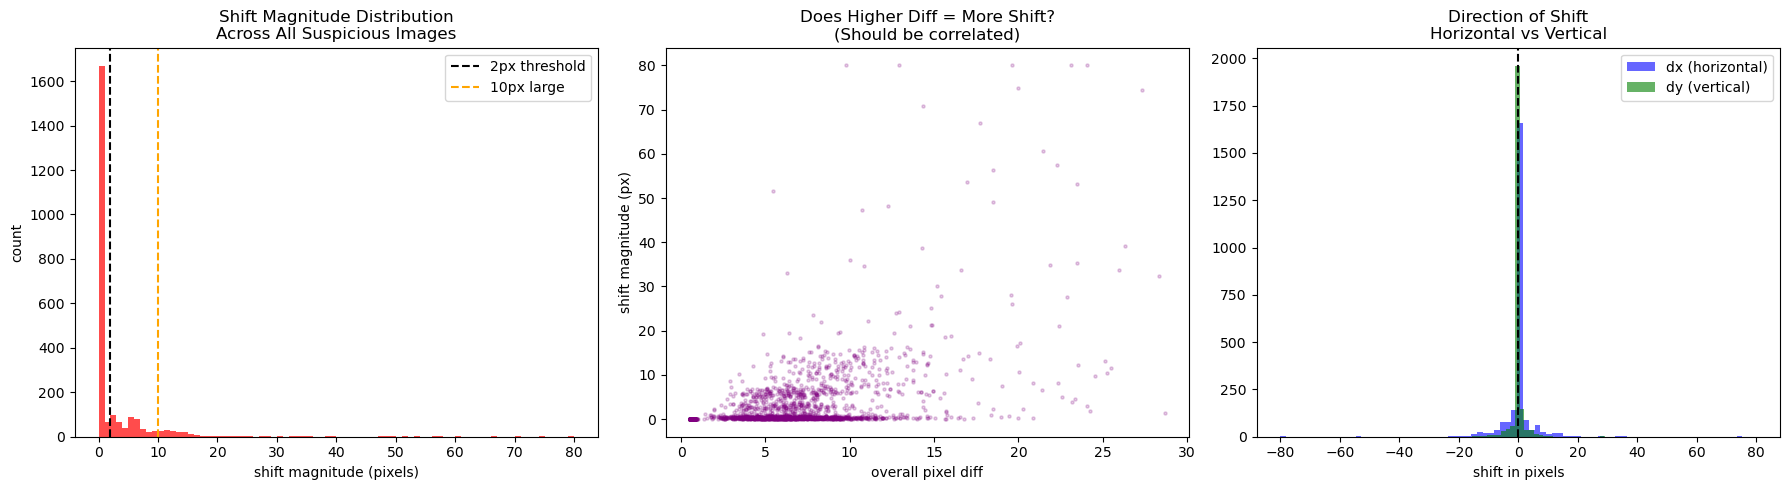

In [8]:
# Full shift analysis on ALL suspicious images
suspicious = df[
    (df["barrel_ratio"] < 1.2) & (df["use_in_train"] == True)
].copy()

print(f"Running shift detection on {len(suspicious)} suspicious images...")

shift_results = []

for _, row in tqdm(suspicious.iterrows(), total=len(suspicious)):
    dist = cv2.imread(row["dist_path"])
    corr = cv2.imread(row["corr_path"])

    if dist is None or corr is None:
        continue

    gray_dist = cv2.cvtColor(dist, cv2.COLOR_BGR2GRAY).astype(np.float32)
    gray_corr = cv2.cvtColor(corr, cv2.COLOR_BGR2GRAY).astype(np.float32)

    shift, response = cv2.phaseCorrelate(gray_dist, gray_corr)
    dx, dy = shift
    mag = np.sqrt(dx**2 + dy**2)

    img_id = row["image_id"]
    property_id = img_id.split("_g")[0] if "_g" in img_id else img_id

    shift_results.append({
        "image_id": img_id,
        "property_id": property_id,
        "dx": dx,
        "dy": dy,
        "shift_mag": mag,
        "is_shifted": mag > 2.0,
        "overall_diff": row["overall_diff"],
        "category": row["category"],
    })

df_shifts = pd.DataFrame(shift_results)
df_shifts.to_csv("shift_analysis.csv", index=False)

print("\n" + "=" * 50)
print("SHIFT ANALYSIS RESULTS")
print("=" * 50)

print(f"\nTotal suspicious analyzed: {len(df_shifts):,}")
print(
    f"Has significant shift (>2px): {df_shifts['is_shifted'].sum():,} "
    f"({100*df_shifts['is_shifted'].mean():.1f}%)"
)
print(
    f"No significant shift (<2px):  {(~df_shifts['is_shifted']).sum():,} "
    f"({100*(~df_shifts['is_shifted']).mean():.1f}%)"
)

print(f"\nShift magnitude distribution:")
print(f"  <2px  (no shift):    {(df_shifts['shift_mag']<2).sum():,}")
print(f"  2-5px (tiny):        {((df_shifts['shift_mag']>=2)&(df_shifts['shift_mag']<5)).sum():,}")
print(f"  5-15px (moderate):   {((df_shifts['shift_mag']>=5)&(df_shifts['shift_mag']<15)).sum():,}")
print(f"  15-30px (large):     {((df_shifts['shift_mag']>=15)&(df_shifts['shift_mag']<30)).sum():,}")
print(f"  >30px (massive):     {(df_shifts['shift_mag']>=30).sum():,}")

print(f"\nMax shift:    {df_shifts['shift_mag'].max():.1f} px")
print(f"Mean shift:   {df_shifts['shift_mag'].mean():.1f} px")
print(f"Median shift: {df_shifts['shift_mag'].median():.1f} px")

print(f"\nProperty-level analysis:")
print(f"  Unique properties in suspicious: {df_shifts['property_id'].nunique():,}")

prop_shift = df_shifts.groupby("property_id")["is_shifted"].mean()
print(f"  Properties where ALL images shifted:  {(prop_shift==1.0).sum():,}")
print(f"  Properties where SOME images shifted: {((prop_shift>0)&(prop_shift<1)).sum():,}")
print(f"  Properties where NO images shifted:   {(prop_shift==0.0).sum():,}")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(
    df_shifts["shift_mag"].clip(0, 80),
    bins=80, color="red", alpha=0.7, edgecolor="none",
)
axes[0].axvline(x=2, color="black", linestyle="--", label="2px threshold")
axes[0].axvline(x=10, color="orange", linestyle="--", label="10px large")
axes[0].set_xlabel("shift magnitude (pixels)")
axes[0].set_ylabel("count")
axes[0].set_title("Shift Magnitude Distribution\nAcross All Suspicious Images")
axes[0].legend()

axes[1].scatter(
    df_shifts["overall_diff"],
    df_shifts["shift_mag"].clip(0, 80),
    alpha=0.2, s=5, color="purple",
)
axes[1].set_xlabel("overall pixel diff")
axes[1].set_ylabel("shift magnitude (px)")
axes[1].set_title("Does Higher Diff = More Shift?\n(Should be correlated)")

axes[2].hist(
    df_shifts["dx"].clip(-80, 80), bins=80, alpha=0.6, color="blue", label="dx (horizontal)"
)
axes[2].hist(
    df_shifts["dy"].clip(-80, 80), bins=80, alpha=0.6, color="green", label="dy (vertical)"
)
axes[2].axvline(x=0, color="black", linestyle="--")
axes[2].set_xlabel("shift in pixels")
axes[2].set_title("Direction of Shift\nHorizontal vs Vertical")
axes[2].legend()

plt.tight_layout()
plt.savefig("shift_distribution.png", dpi=150)
plt.show()

In [9]:

partial_properties = df_shifts[
    df_shifts['property_id'].isin(
        df_shifts.groupby('property_id')['is_shifted']
        .apply(lambda x: x.any() and not x.all())
        .index[df_shifts.groupby('property_id')['is_shifted']
               .apply(lambda x: x.any() and not x.all())]
    )
]

within_property = partial_properties.groupby('property_id').agg(
    total=('image_id','count'),
    shifted=('is_shifted','sum'),
    not_shifted=('is_shifted', lambda x: (~x).sum()),
    mean_diff=('overall_diff','mean')
).reset_index()

print("Partially shifted properties:")
print(f"  Total:                    {len(within_property)}")
print(f"  Mean images per property: {within_property['total'].mean():.1f}")
print(f"  Shifted per property:     {within_property['shifted'].mean():.1f}")
print(f"  Non-shifted per property: {within_property['not_shifted'].mean():.1f}")

Partially shifted properties:
  Total:                    180
  Mean images per property: 2.7
  Shifted per property:     1.3
  Non-shifted per property: 1.4


In [12]:
import pandas as pd

df = pd.read_csv('full_dataset_clean.csv')
df_shifts = pd.read_csv('shift_analysis.csv')

# Merge shift info back to main dataframe
df = df.merge(
    df_shifts[['image_id','shift_mag','dx','dy','is_shifted']],
    on='image_id',
    how='left'
)

# For non-suspicious images shift was not computed → fill with 0
df['shift_mag']  = df['shift_mag'].fillna(0)
df['is_shifted'] = df['is_shifted'].fillna(False)

# ── Final use_in_train decision ──
def final_decision(row):

    # Rule 1: Already marked as remove
    if row['category'] == 'identical':
        return False, 0.0, 'identical_remove'

    # Rule 2: Shifted images
    if row['is_shifted']:
        return False, 0.0, 'shifted_remove'

    # Rule 3: Mild distortion
    if row['category'] == 'mild':
        return True, 0.3, 'mild_keep'

    # Rule 4: Heavy distortion
    if row['category'] == 'heavy':
        return True, 5.0, 'heavy_keep'

    # Rule 5: Everything else
    return True, 1.0, 'normal_keep'

results = df.apply(final_decision, axis=1, result_type='expand')
df['use_in_train'] = results[0]
df['weight']       = results[1]
df['final_reason'] = results[2]

df.to_csv('final_clean_dataset.csv', index=False)

# ── Final summary ──
print("=" * 55)
print("FINAL CLEAN DATASET")
print("=" * 55)
print(f"\nTotal pairs:           {len(df):,}")
print(f"\nREMOVED:")
print(f"  Identical:           "
      f"{(df['final_reason']=='identical_remove').sum():,}")
print(f"  Shifted:             "
      f"{(df['final_reason']=='shifted_remove').sum():,}")
print(f"  Total removed:       "
      f"{(~df['use_in_train']).sum():,}")
print(f"\nKEPT FOR TRAINING:")
print(f"  Mild    (w=0.3):     "
      f"{(df['final_reason']=='mild_keep').sum():,}")
print(f"  Normal  (w=1.0):     "
      f"{(df['final_reason']=='normal_keep').sum():,}")
print(f"  Heavy   (w=5.0):     "
      f"{(df['final_reason']=='heavy_keep').sum():,}")
print(f"\nFINAL TRAINING SET:    "
      f"{df['use_in_train'].sum():,}")

# ── Effective sample count with weights ──
train = df[df['use_in_train']]
effective = (train['weight']).sum()
print(f"EFFECTIVE WEIGHTED:    {effective:,.0f}")




/var/folders/64/glschqjx3sn28wyvf5wwcx2r0000gn/T/ipykernel_18270/2519887859.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_shifted'] = df['is_shifted'].fillna(False)


FINAL CLEAN DATASET

Total pairs:           23,118

REMOVED:
  Identical:           134
  Shifted:             651
  Total removed:       785

KEPT FOR TRAINING:
  Mild    (w=0.3):     697
  Normal  (w=1.0):     21,517
  Heavy   (w=5.0):     119

FINAL TRAINING SET:    22,333
EFFECTIVE WEIGHTED:    22,321
